## MLS Case study: Unsupervised Learning
----------------------------------------

Welcome to the case study on Unsupervised Learning. We will be using the Credit Card Customer Data for this case study.

----------------------------
## Problem Statement: 
-----------------------------
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. The Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.


----------------------------
## Objective: 
-----------------------------

Identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

--------------------------
## About the data:
--------------------------
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.

- Sl_no - Customer Serial Number
- Customer Key - Customer identification
- Avg_Credit_Limit	- Average credit limit (currency is not specified, you can make an assumption around this)
- Total_Credit_Cards	- Total number of credit cards 
- Total_visits_bank	- Total bank visits
- Total_visits_online -	 Total online visits
- Total_calls_made - Total calls made

## Importing libraries and overview of the dataset

In [3]:
#Import all the necessary packages

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

#importing clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Loading data

In [4]:
data = pd.read_csv('Credit Card Customer Data.csv')
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


#### Check the info of the data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


**Observations:**

- There are 655 observations and 7 columns in the dataset.
- All columns have 655 non-null values i.e. there are no missing values.
- All columns are of int64 data type.

**There are no missing values. Let us now figure out the uniques in each column.** 

In [6]:
data.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

- Customer key, which is an identifier, has no repeated values. We should treat the same accordingly before applying any algorithm.

## Data Preprocessing and Exploratory Data Analysis

First we need to drop the variables that are not required for our analysis.

In [7]:
data.drop(columns = ['Sl_No', 'Customer Key'], inplace = True)

Now that we have dropped unnecessary column. We can again check for duplicates. Duplicates would mean customers with identical features.

In [8]:
data[data.duplicated()]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
162,8000,2,0,3,4
175,6000,1,0,2,5
215,8000,4,0,4,7
295,10000,6,4,2,3
324,9000,4,5,0,4
361,18000,6,3,1,4
378,12000,6,5,2,1
385,8000,7,4,2,0
395,5000,4,5,0,1
455,47000,6,2,0,4


We can drop these duplicated rows from the data

In [9]:
data=data[~data.duplicated()]

In [10]:
data.shape

(649, 5)

- After removing duplicated keys and rows and unnecessary columns, there are 644 unique observations and 5 columns in our data.

#### Summary Statistics

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,649.0,34878.274268,37813.736638,3000.0,11000.0,18000.0,49000.0,200000.0
Total_Credit_Cards,649.0,4.708783,2.173763,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,649.0,2.397535,1.625148,0.0,1.0,2.0,4.0,5.0
Total_visits_online,649.0,2.624037,2.952888,0.0,1.0,2.0,4.0,15.0
Total_calls_made,649.0,3.590139,2.877911,0.0,1.0,3.0,5.0,10.0


**Observations:**

- The average credit limit has a high range as it has a minimum value of 3K and a maximum value of 200K.
- The mean of the average credit limit is approx 34.5K with a large standard deviation of 37.4K.
- The average number of cards per customer is approx 5 (rounding off to nearest integer).
- On average, a customer has 2 bank visits, 3 online visits, and made 4 calls. 

#### Now let's go ahead with the exploring each variable at hand. We will check the distribution and outliers for each variable in the data.

Avg_Credit_Limit
Skew : 2.19


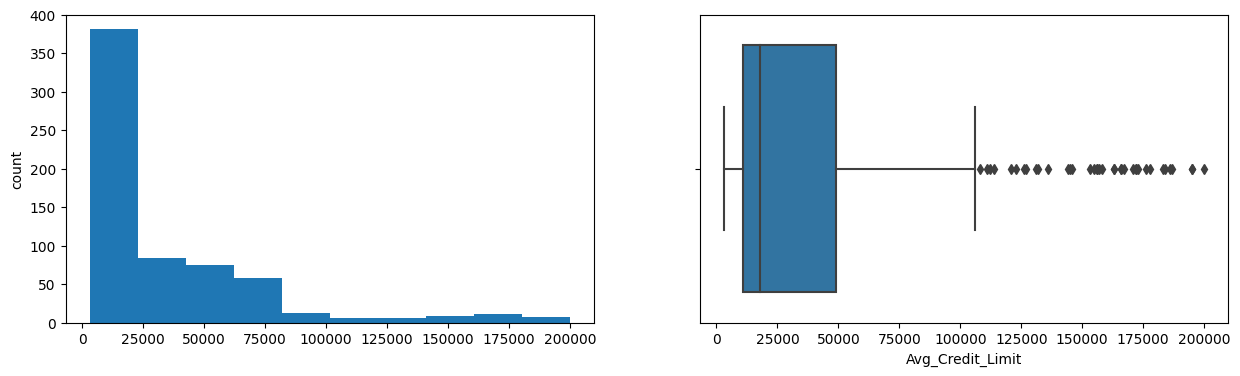

Total_Credit_Cards
Skew : 0.15


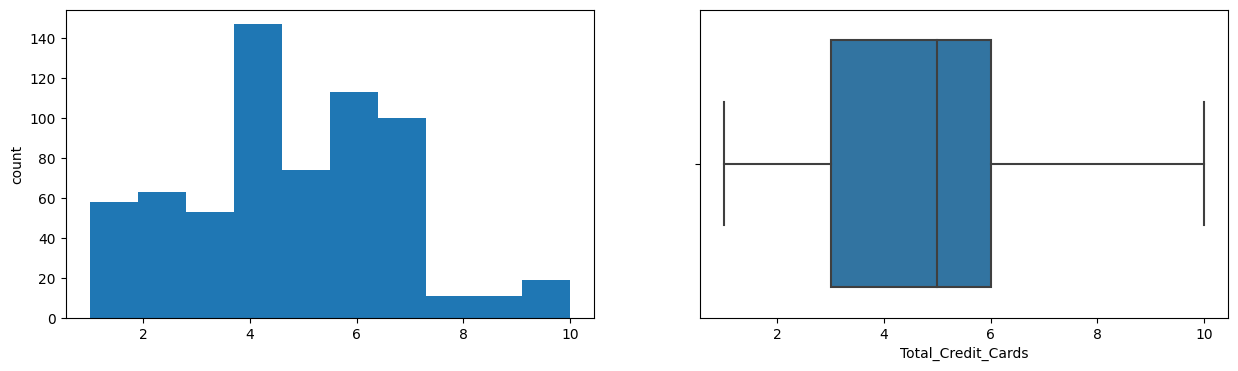

Total_visits_bank
Skew : 0.15


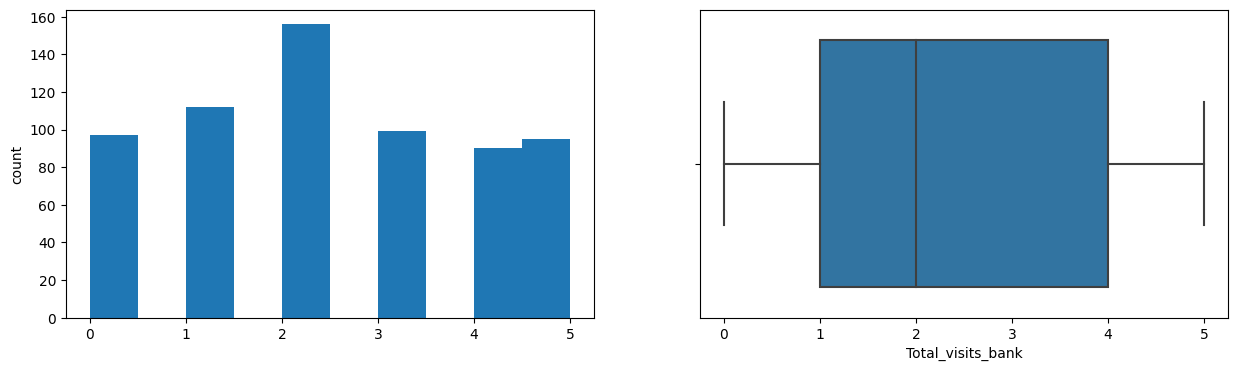

Total_visits_online
Skew : 2.21


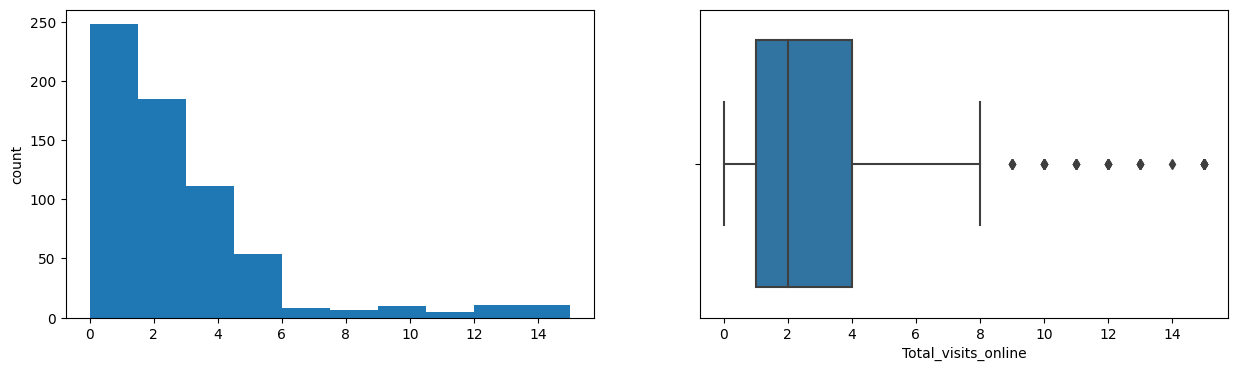

Total_calls_made
Skew : 0.66


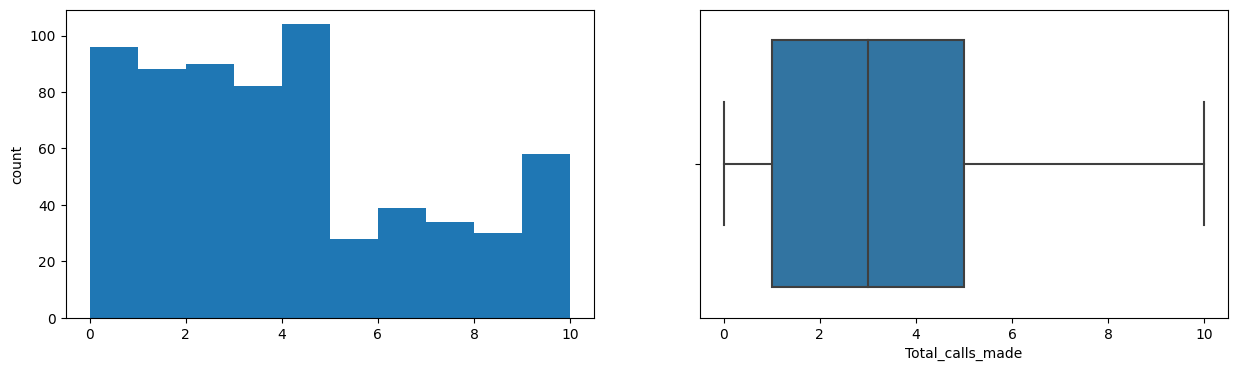

In [12]:
for col in data.columns:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observation:**

- The average credit limit and total visits online has a right skewed distribution with some outliers.
- The majority of customers have 4 credits cards, 2 bank visits, and 4 calls.

**Now, let's check the correlation among different variables.**

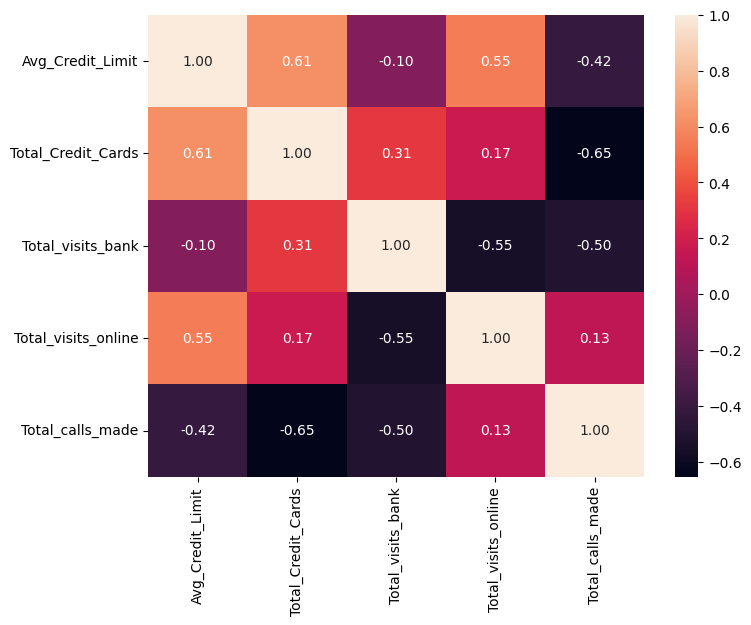

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, fmt='0.2f')
plt.show()

**Observation:**

- Avg_Credit_Limit is positively correlated with Total_Credit_Cards and Total_visits_online which can makes sense.
- Avg_Credit_Limit is negatively correlated with Total_calls_made and Total_visits_bank.
- Total_visits_bank, Total_visits_online, Total_calls_made are negatively correlated which implies that majority of customers use only one of these channels to contact the bank.

#### Scaling the data

In [14]:
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [15]:
data_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.723499,-1.247087,-0.860606,-0.550407,-1.248443
1,0.400209,-0.786701,-1.476410,2.499808,1.881237
2,0.400209,1.054846,-0.860606,0.127419,0.142526
3,-0.129107,0.134072,-0.860606,-0.550407,0.142526
4,1.723499,0.594459,-1.476410,3.177634,-0.205216


In [16]:
#Creating copy of the data to store labels from each algorithm
data_scaled_copy = data_scaled.copy(deep=True)

## K-Means

Let us now fit k-means algorithm on our scaled data and find out the optimum number of clusters to use.

We will do this in 3 steps:
1. Initialize a dictionary to store the SSE for each k
2. Run for a range of Ks and store SSE for each run
3. Plot the SSE vs K and find the elbow

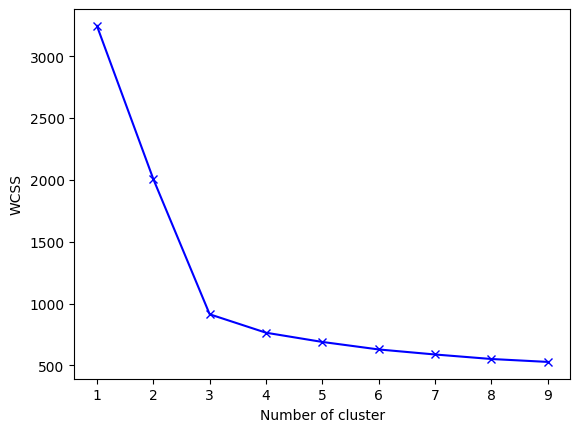

In [17]:
# step 1
WCSS = {} 

# step 2 - iterate for a range of Ks and fit the scaled data to the algorithm. Use inertia attribute from the clustering object and 
# store the inertia value for that k 
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_scaled)
    WCSS[k] = kmeans.inertia_

# step 3
plt.figure()
plt.plot(list(WCSS.keys()), list(WCSS.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("WCSS")
plt.show()

**Observations:**
- Looking at the plot, we can say that elbow point is achieved for k=3.
- We will fit the k-means again with k=3 to get the labels.

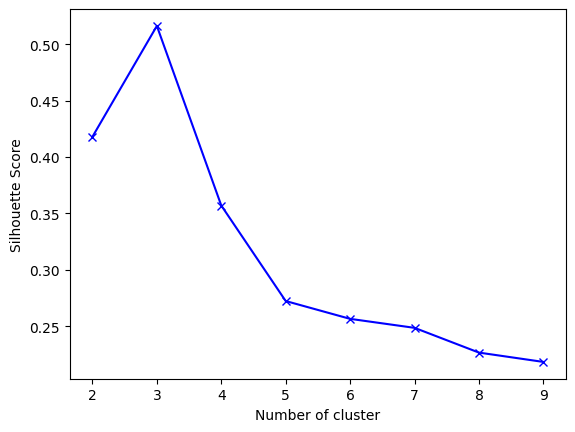

In [18]:
#Empty dictionary to store the Silhouette score for each value of k
sc = {} 

# iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that k 
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(data_scaled)
    labels = kmeans.predict(data_scaled)
    sc[k] = silhouette_score(data_scaled, labels)

#Elbow plot
plt.figure()
plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()


**Fitting the K-means algorithms on the scaled data with number of cluster equal to 3 and Storing the predictions as 'Labels' to the 'data_scaled_copy' and 'data' dataframes**

In [19]:
kmeans = KMeans(n_clusters=3, max_iter= 1000, random_state=1)
kmeans.fit(data_scaled)

#Adding predicted labels to the original data and scaled data 
data_scaled_copy['Labels'] = kmeans.predict(data_scaled)
data['Labels'] = kmeans.predict(data_scaled)

We have generated the labels with k-means. Let us look at the various features based on the labels.

#### **Creating cluster profiles using the below summary statistics and box plots for each label**

In [20]:
#Number of observations in each cluster
data.Labels.value_counts()

Labels
1    378
0    221
2     50
Name: count, dtype: int64

In [21]:
#Calculating summary statistics of the original data for each label
mean = data.groupby('Labels').mean()
median = data.groupby('Labels').median()
df_kmeans = pd.concat([mean, median], axis=0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_kmeans.T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,12239.819005,34071.428571,141040.00,12000.0,32000.0,145500.0
Total_Credit_Cards,2.411765,5.518519,8.74,2.0,6.0,9.0
Total_visits_bank,0.945701,3.484127,0.60,1.0,3.0,1.0
Total_visits_online,3.561086,0.981481,10.90,4.0,1.0,11.0
Total_calls_made,6.891403,1.992063,1.08,7.0,2.0,1.0


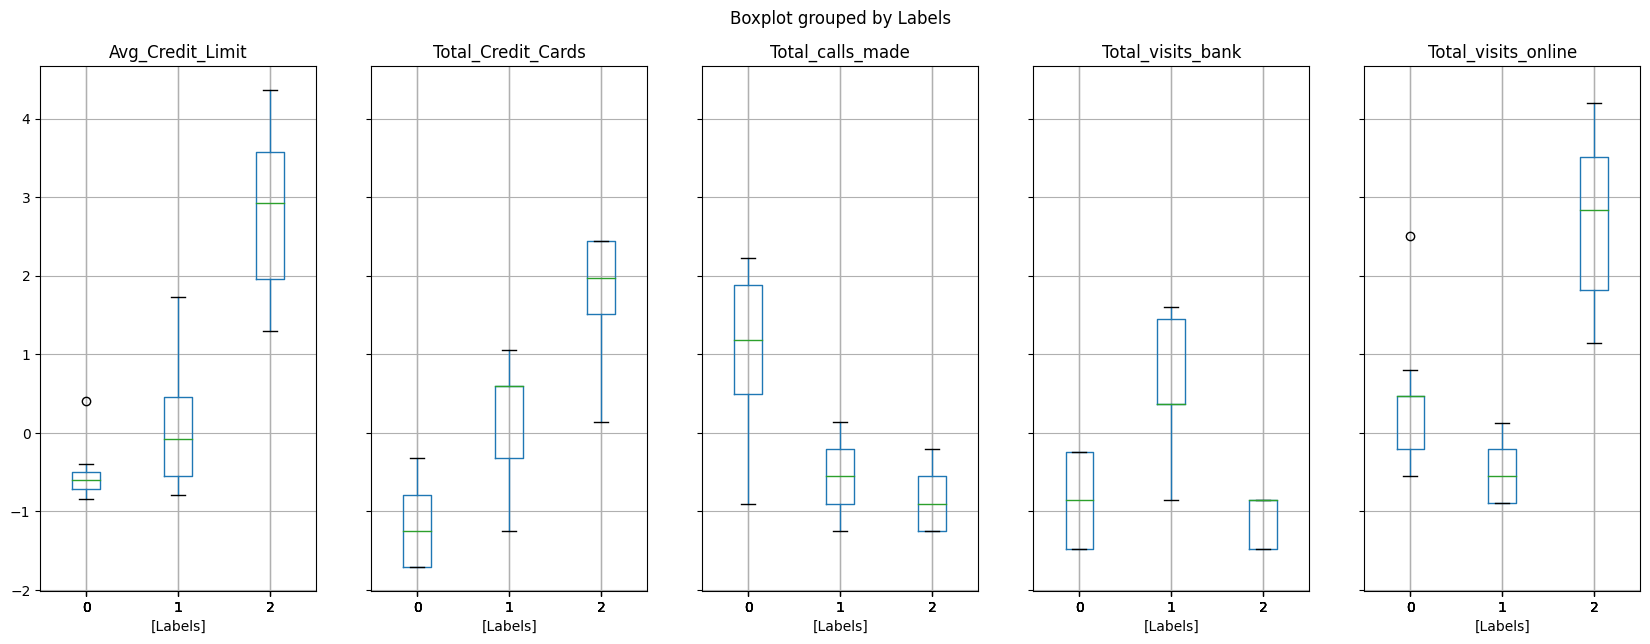

In [22]:
#Visualizing different features w.r.t K-means labels
data_scaled_copy.boxplot(by = 'Labels', layout = (1,5),figsize=(20,7))
plt.show()

**Cluster Profiles:**
- Cluster 0 - Low Credit Cutsomers: This cluster represents customers with low spending and prefers to interact with the bank via calls and therefore they have less number of bank and online visits.
- Cluster 1 - Medium Credit Customers: This cluster represents customers who spends comparatively more than low credit customers and visits the bank more often and therefore they have less number of calls and online visits.
- Cluster 2 - High Credit Customers: This cluster represents customers with high spending and prefers to contact the bank through online channel and therefore they have less number of total calls and bank visits.

## K-Medoids

In [23]:
kmedo = KMedoids(n_clusters = 3, random_state=1)
kmedo.fit(data_scaled)

data_scaled_copy['kmedoLabels'] = kmedo.predict(data_scaled)
data['kmedoLabels'] = kmedo.predict(data_scaled)

In [24]:
#Number of observations in each cluster
data.kmedoLabels.value_counts()

kmedoLabels
2    273
0    221
1    155
Name: count, dtype: int64

**Creating cluster profiles using the below summary statistics and box plots for each label and Comparing the clusters from both algorithms - K-Means and K-Medoids**

In [25]:
#Calculating summary statistics of the original data for each label
original_features = ["Avg_Credit_Limit","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]

mean = data.groupby('kmedoLabels').mean()
median = data.groupby('kmedoLabels').median()
df_kmedoids = pd.concat([mean, median], axis=0)
df_kmedoids.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_kmedoids[original_features].T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,12203.619910,80625.806452,27260.073260,12000.0,66000.0,19000.0
Total_Credit_Cards,2.420814,6.741935,5.406593,2.0,7.0,6.0
Total_visits_bank,0.954751,1.800000,3.904762,1.0,2.0,4.0
Total_visits_online,3.565611,4.187097,0.974359,4.0,2.0,1.0
Total_calls_made,6.904977,2.006452,1.805861,7.0,2.0,2.0


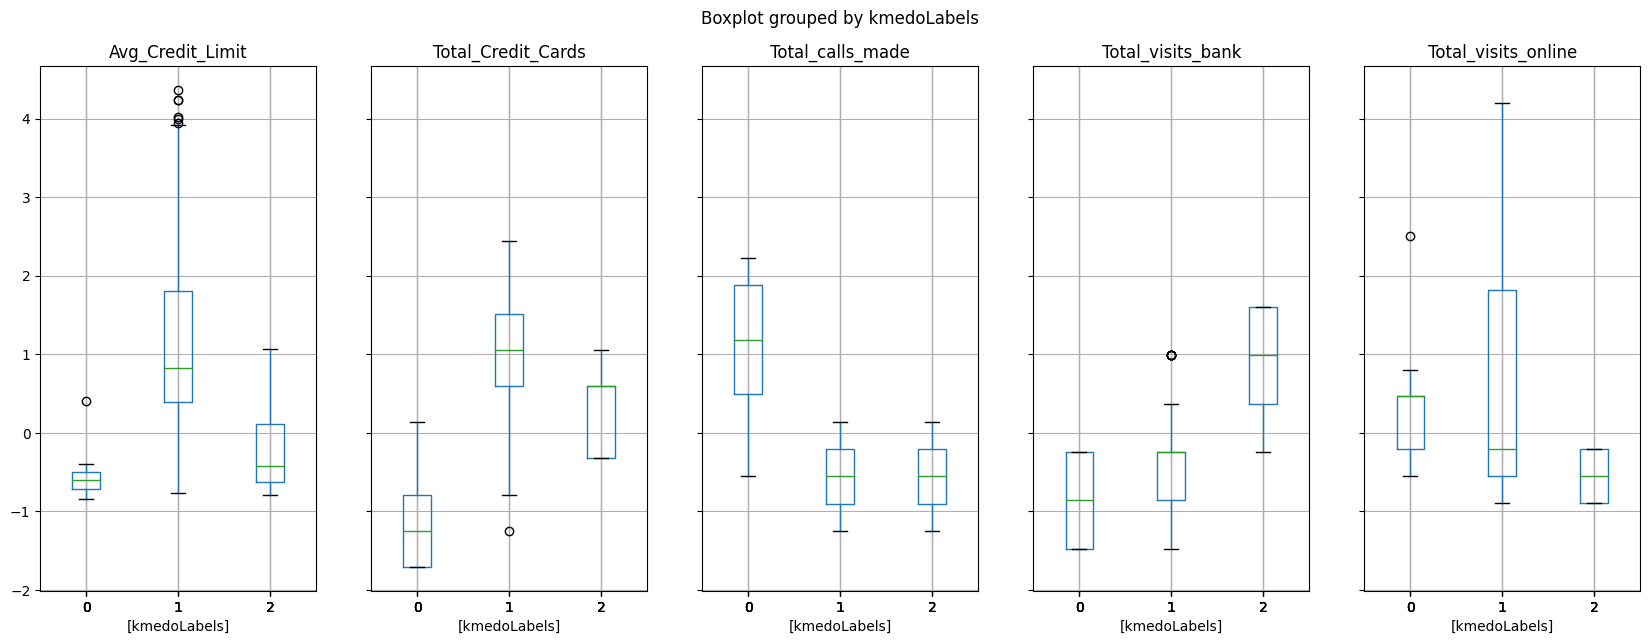

In [26]:
#plotting boxplots with the new K-Medoids based labels

features_with_lables = ["Avg_Credit_Limit",	"Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made","kmedoLabels"]

data_scaled_copy[features_with_lables].boxplot(by = 'kmedoLabels', layout = (1,5),figsize=(20,7))
plt.show()

Let's compare the clusters from K-Means and K-Medoids 

In [27]:
comparison = pd.concat([df_kmedoids, df_kmeans], axis=1)[original_features]
comparison

,Avg_Credit_Limit,Avg_Credit_Limit,Total_Credit_Cards,Total_Credit_Cards,Total_visits_bank,Total_visits_bank,Total_visits_online,Total_visits_online,Total_calls_made,Total_calls_made
group_0 Mean,12203.619910,12239.819005,2.420814,2.411765,0.954751,0.945701,3.565611,3.561086,6.904977,6.891403
group_1 Mean,80625.806452,34071.428571,6.741935,5.518519,1.800000,3.484127,4.187097,0.981481,2.006452,1.992063
group_2 Mean,27260.073260,141040.000000,5.406593,8.740000,3.904762,0.600000,0.974359,10.900000,1.805861,1.080000
group_0 Median,12000.000000,12000.000000,2.000000,2.000000,1.000000,1.000000,4.000000,4.000000,7.000000,7.000000
group_1 Median,66000.000000,32000.000000,7.000000,6.000000,2.000000,3.000000,2.000000,1.000000,2.000000,2.000000
group_2 Median,19000.000000,145500.000000,6.000000,9.000000,4.000000,1.000000,1.000000,11.000000,2.000000,1.000000


**Cluster Profiles:**
- Cluster 0 - Low Credit Cutsomers: This cluster represents customers with low spending and prefers to interact with the bank via calls and therefore they have less number of bank and online visits.
- Cluster 1 - High Credit Customers: This cluster represents customers with high spending and prefers to contact the bank through online channel and therefore they have less number of total calls and bank visits.
- Cluster 2 - Medium Credit Customers: This cluster represents customers who spends comparatively more than low credit customers and visits the bank more often and therefore they have less number of calls and online visits.

**Comparing Clusters:**

- The size of clusters (count of observations) from K-Medoids is different from K-means clusters. In K-Medoids, number of observations are evenly distributed among clusters. 
- K-Medoids clusters are more compact i.e. have small ranges for all variables. For example, the range of total number of credit cards is from 4 to 7 for medium credit customers from K-Medoids, whereas from K-Means, it is from 2 to 7.
- K-Medoids is more robust to outliers which helps to identify outliers in the clusters. For example, the total number of bank visits has an outlier for high credit customers from K-Medoids, whereas from K-Means, we could not detect any outliers in this variable.

## **Additional Content (Optional)**

## Gaussian Mixture

Let's create clusters using Gaussian Mixture Models

**Finding Optimal K using Silhouette for GMM model**

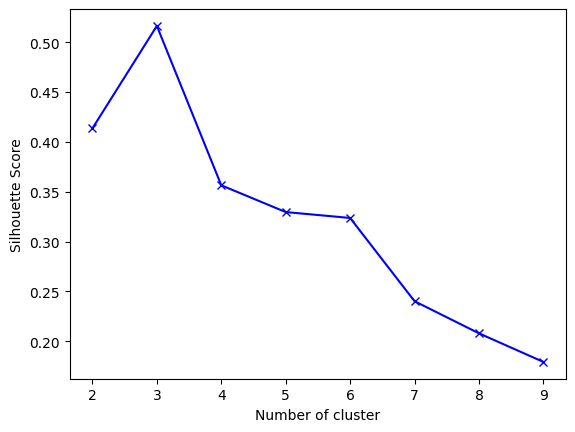

In [28]:
#Empty dictionary to store the Silhouette score for each value of k
sc = {} 

# iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that k 
for k in range(2, 10):
    GMM = GaussianMixture(n_components = k).fit(data_scaled)
    labels = GMM.predict(data_scaled)
    sc[k] = silhouette_score(data_scaled, labels)

#Elbow plot
plt.figure()
plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

**Fitting the GMM model** 

In [29]:
gmm = GaussianMixture(n_components = 3)
gmm.fit(data_scaled)

data_scaled_copy['GmmLabels'] = gmm.predict(data_scaled)
data['GmmLabels'] = gmm.predict(data_scaled)

In [30]:
#Number of observations in each cluster
data.GmmLabels.value_counts()

GmmLabels
0    378
1    221
2     50
Name: count, dtype: int64

**Creating cluster profiles using the below summary statistics and box plots for each label and Comparing the clusters from both algorithms - K-means and Gaussian Mixture**

In [31]:
#Calculating summary statistics of the original data for each label
original_features = ["Avg_Credit_Limit","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]

mean = data.groupby('GmmLabels').mean()
median = data.groupby('GmmLabels').median()
df_gmm = pd.concat([mean, median], axis=0)
df_gmm.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_gmm[original_features].T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,34071.428571,12239.819005,141040.00,32000.0,12000.0,145500.0
Total_Credit_Cards,5.518519,2.411765,8.74,6.0,2.0,9.0
Total_visits_bank,3.484127,0.945701,0.60,3.0,1.0,1.0
Total_visits_online,0.981481,3.561086,10.90,1.0,4.0,11.0
Total_calls_made,1.992063,6.891403,1.08,2.0,7.0,1.0


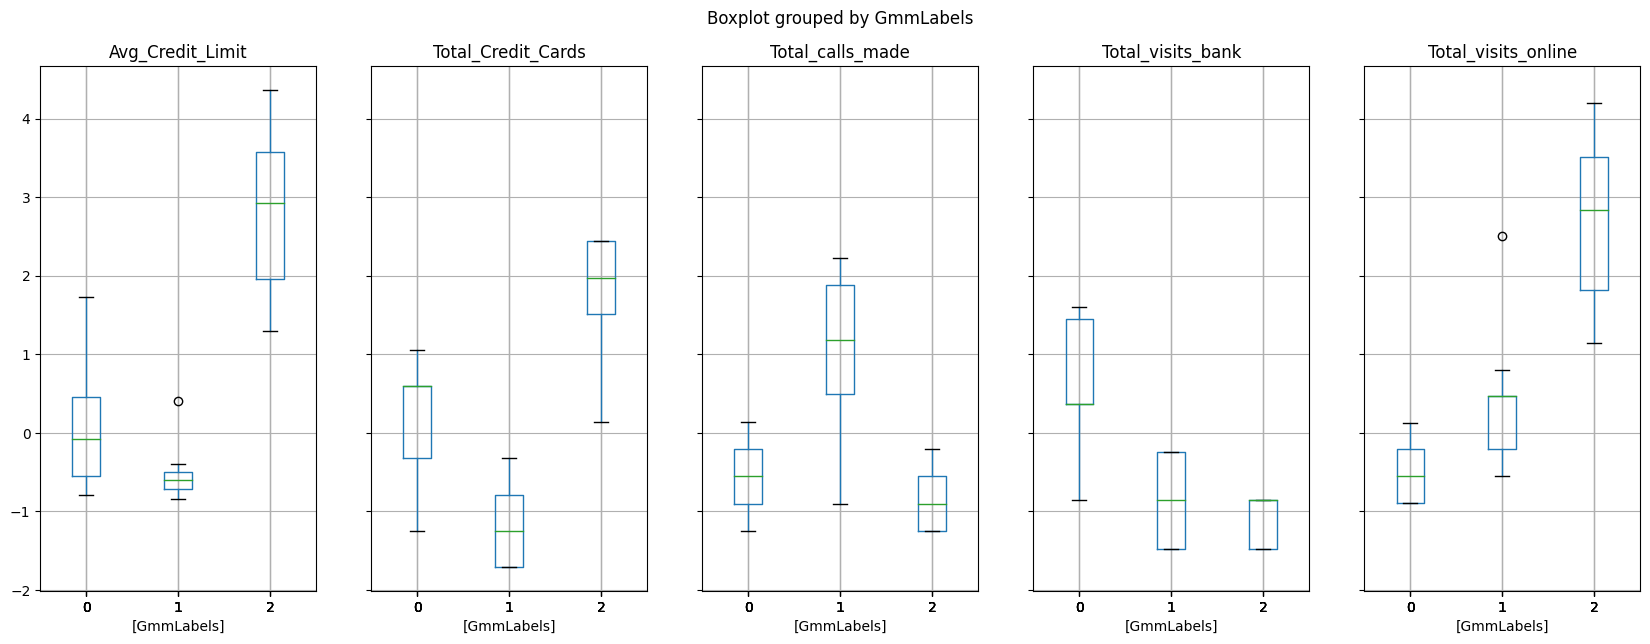

In [32]:
# plotting boxplots with the new GMM based labels

features_with_lables = ["Avg_Credit_Limit","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made","GmmLabels"]

data_scaled_copy[features_with_lables].boxplot(by = 'GmmLabels', layout = (1,5),figsize=(20,7))
plt.show()

**Cluster Profiles:**

- Cluster 0 - Low Credit Cutsomers: This cluster represents customers with low spending and prefers to interact with the bank via calls and therefore they have less number of bank and online visits.
- Cluster 1 - Medium Credit Customers: This cluster represents customers who spends comparatively more than low credit customers and visits the bank more often and therefore they have less number of calls and online visits.
- Cluster 2 - High Credit Customers: This cluster represents customers with high spending and prefers to contact the bank through online channel and therefore they have less number of total calls and bank visits.

**Comparing Clusters:**

- The cluster profiles are the same as the K-means clusters.